In [11]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [12]:
import pickle
import pandas as pd
import torch
from pathlib import Path
from artifact import Saw
from detector import SlidingWindowTransformerDetector
from data import RealisticArtifactDataset, CachedArtifactDataset
import numpy as np
from itertools import repeat


/opt/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test_datasets = [
    # "australian_electricity_demand_dataset", # accuracy  ~0.95
    # "electricity_hourly_dataset", # accuracy ~0.976
    # "electricity_load_diagrams", # ~0.953
    "HouseholdPowerConsumption1",
    #"HouseholdPowerConsumption2",
    #"london_smart_meters_dataset_without_missing_values",
    #"solar_10_minutes_dataset",
    #"wind_farms_minutely_dataset_without_missing_values",
]

In [17]:
def load_series(names: list[str], split: str):
    series = list()
    counts = list()
    for name in names:
        with open(f"../data/processed_HH/{name}_{split}.pickle", "rb") as f:
            raw = [a for a in pickle.load(f) if len(a) > 512]
            series.extend(np.array(a).astype(np.float32) for a in raw)
            counts.extend(repeat(1 / len(raw), len(raw)))
    counts = np.array(counts)
    return series, counts / counts.sum()

In [20]:
hh1_data, hh1_weights = load_series(["HouseholdPowerConsumption1"], "TRAIN")
hh2_data, hh2_weights = load_series(["HouseholdPowerConsumption2"], "TRAIN")

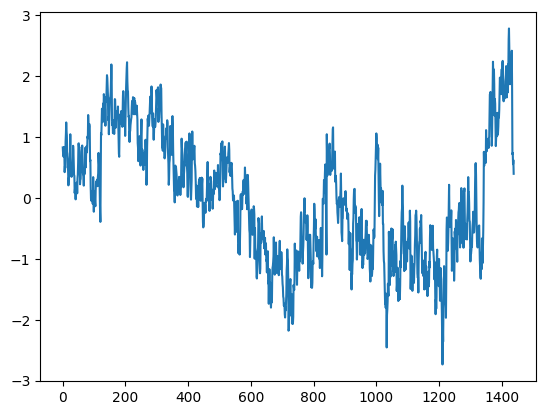

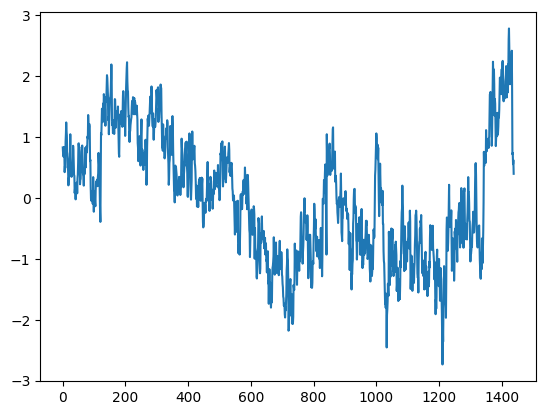

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [21]:
import matplotlib.pyplot as plt

plt.plot(hh1_data[0])
plt.show()
plt.plot(hh2_data[0])
plt.show()
sums = []
for i in range(len(hh1_data)):
    sums.append(sum([a_i - b_i for a_i, b_i in zip(hh1_data[i], hh2_data[i])]))

print(sums)
print(sum(sums))

In [5]:
# validation
if not test_file.exists():
    val_data, val_weights = load_series(test_datasets, "VAL")
    val_gen = RealisticArtifactDataset(val_data,
                              width=test_width,
                              padding=64,
                              artifact=Saw(),
                              weight=val_weights)
    val = CachedArtifactDataset.generate(val_gen,
                                         n=2048,
                                         to=test_file)
else:
    val = CachedArtifactDataset(file=test_file)

In [6]:
detector = WindowTransformerDetector.load_from_checkpoint("../models/model.ckpt").cpu()


/opt/miniconda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.8, which is newer than your current Lightning version: v2.0.0
  rank_zero_warn(


In [7]:
def baseline_detector(input: torch.Tensor) -> torch.Tensor:
    prediction = torch.zeros(input.shape)
    # Calculate increments by subtracting the tensor shifted by one from the original tensor
    increments = (input[1:] - input[:-1]).abs()
    mean_increment = torch.mean(increments)
    std_increment = torch.std(increments)
    mask = increments > mean_increment + 0.5*std_increment
    shaped_mask = torch.cat((mask, torch.Tensor([False]))).type(torch.bool)
    prediction[shaped_mask] = 1

    return prediction


In [10]:
example = val[14]
stride  = 64
window  = detector.window
length  = len(example["data"])

example_data = torch.tensor(example["data"] + example["artifact"])
predictions = torch.zeros(((length - window) // stride + 1, length))
masks = torch.zeros(length)
# slice out window
s = example_data[0 : 0 + window]
# make prediction and insert into prediction
# predictions[0, 0 : 0 + window] = detector(s.unsqueeze(0))
predictions[0, 0 : 0 + window] = baseline_detector(s)

In [66]:
baseline_detector(s).shape

torch.Size([512])

In [38]:
import numpy as np

rng = np.random.default_rng()
rng.choice(2)

0

In [10]:
test_width = 1024

val = Path("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/validation_slidingWindow_512.pkl")

In [11]:
val = CachedArtifactDataset(file=val)

In [25]:
len(val[0]['artifact'])

512

In [1]:
import pandas as pd

ground_truth = pd.read_csv('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/gt_slidingWindow_realData.csv')

test_width = 512
dist = test_width // 2
start_ind = 13100 + dist
end_ind = 147000 - dist

In [2]:
ground_truth = ground_truth["0"][start_ind : end_ind]

In [3]:
ground_truth.head()

13356    0.0
13357    0.0
13358    0.0
13359    0.0
13360    0.0
Name: 0, dtype: float64

In [4]:
grouped = ground_truth.groupby(ground_truth)

In [5]:
negatives = grouped.get_group(0.0)
positives = grouped.get_group(1.0)

In [6]:
negatives_selection = negatives.sample(n=len(positives))

In [7]:
test_set_real = pd.concat([positives, negatives_selection])

In [8]:
shuffled_test_set = test_set_real.sample(frac=1)

In [9]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

#autheticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config(
    credential=credential,
    path="config.json",
)

Found the config file in: config.json


In [13]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

data_asset = ml_client.data.get("output_Train_GPU_slidingWindow", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_detector = SlidingWindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=30000-v1.ckpt").cpu()

/opt/miniconda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'act_fct' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fct'])`.
  rank_zero_warn(


In [14]:
real_data_df = pd.read_pickle('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/real/normalized_deviation_updated_TEST.pickle') 

In [15]:
torch.set_grad_enabled(False)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix, roc_curve
import pandas as pd

preds_trans = list()
gt = list()

for center in shuffled_test_set.index:
    example = torch.tensor(real_data_df[0][center-dist : center+dist])
    length  = len(example)

    prediction_trans = transformer_detector(example.unsqueeze(0))

    preds_trans = preds_trans + [prediction_trans.numpy()]
    gt = gt + [shuffled_test_set[center]]

In [17]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(gt, preds_trans)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr = thresholds[ix]

Text(0.5, 1.0, 'Validation Precision-Recall curve')

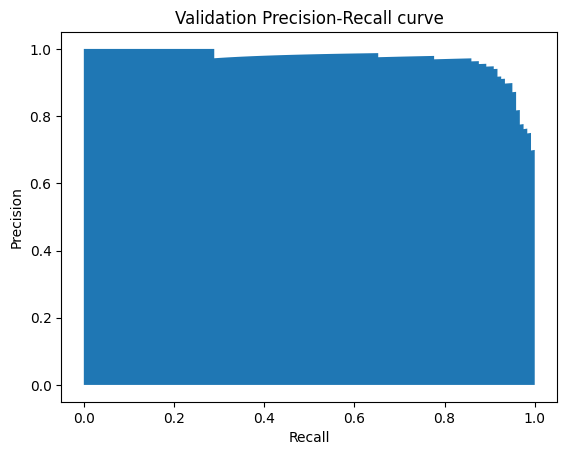

In [18]:
import matplotlib.pyplot as plt

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve")

In [19]:
threshold = best_thresh_pr

preds_binary = [1 if value >= threshold else 0 for value in preds_trans]
tn_trans, fp_trans, fn_trans, tp_trans = confusion_matrix(gt, preds_binary, labels=[0, 1]).ravel()

metrics = pd.DataFrame([{
    'detector': 'slidingWindow_transformer',
    'accuracy': accuracy_score(gt, preds_binary),
    'precision': precision_score(gt, preds_binary),
    'recall': recall_score(gt, preds_binary),
    'mse': mean_squared_error(gt, preds_binary),
    'tn': tn_trans,
    'fp': fp_trans, 
    'fn': fn_trans, 
    'tp': tp_trans
}])

In [20]:
metrics

,detector,accuracy,precision,recall,mse,tn,fp,fn,tp
0,slidingWindow_transformer,0.929752,0.940678,0.917355,0.070248,114,7,10,111


In [ ]:
shuffled_test_set.index.to_list()

In [34]:
df = pd.DataFrame({
    'index': shuffled_test_set.index.to_list(),
    'gt': shuffled_test_set.values,
    'predictions': preds_binary
})

In [39]:
# get false positives
fp_ind = (df.loc[(df['gt'] == 0) & (df['predictions'] == 1)])["index"]
fn_ind = (df.loc[(df['gt'] == 1) & (df['predictions'] == 0)])["index"]
tn_ind = (df.loc[(df['gt'] == 0) & (df['predictions'] == 0)])["index"]

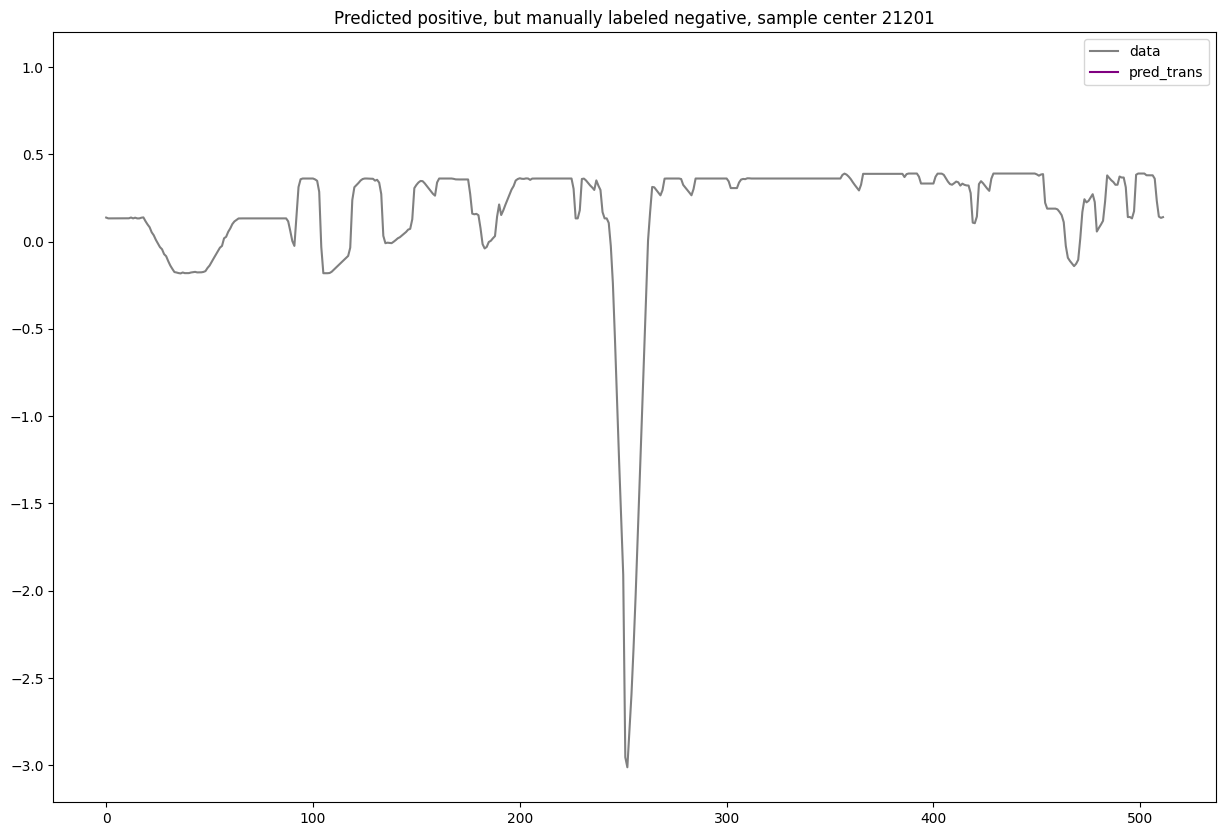

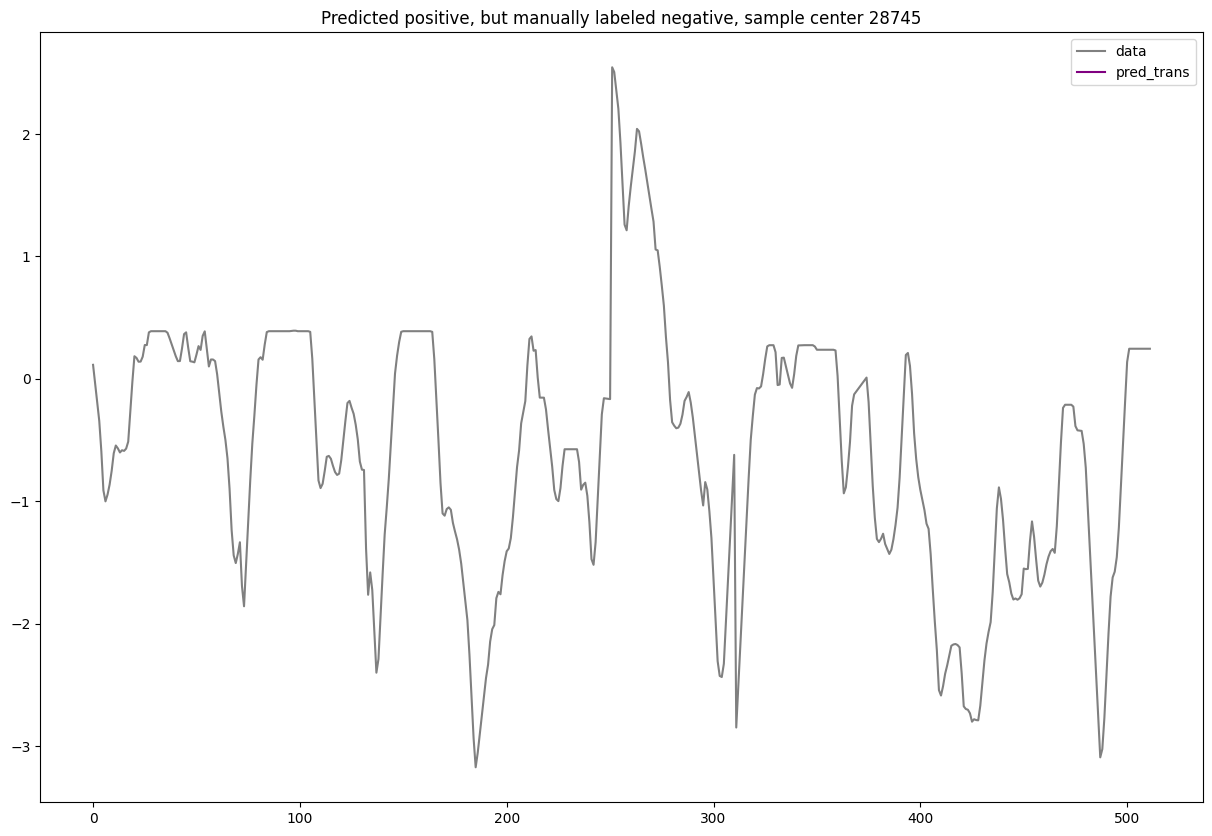

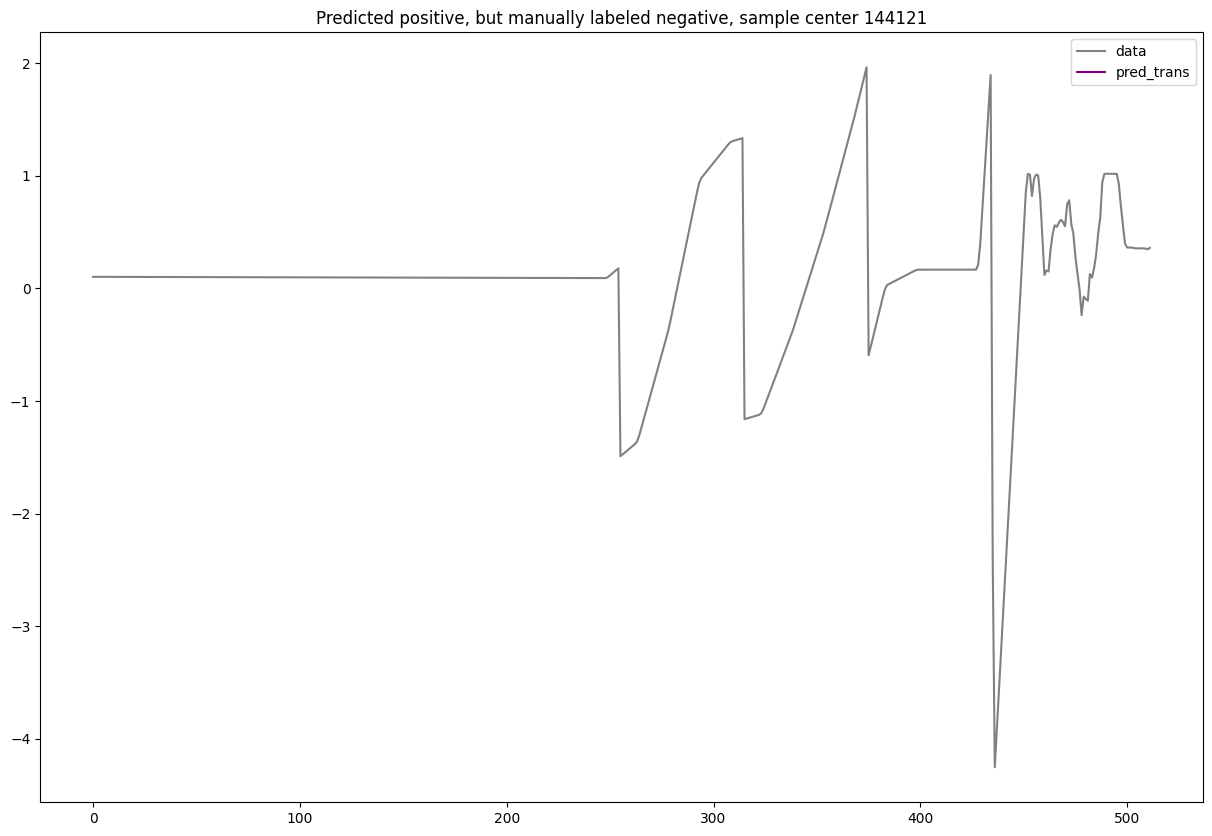

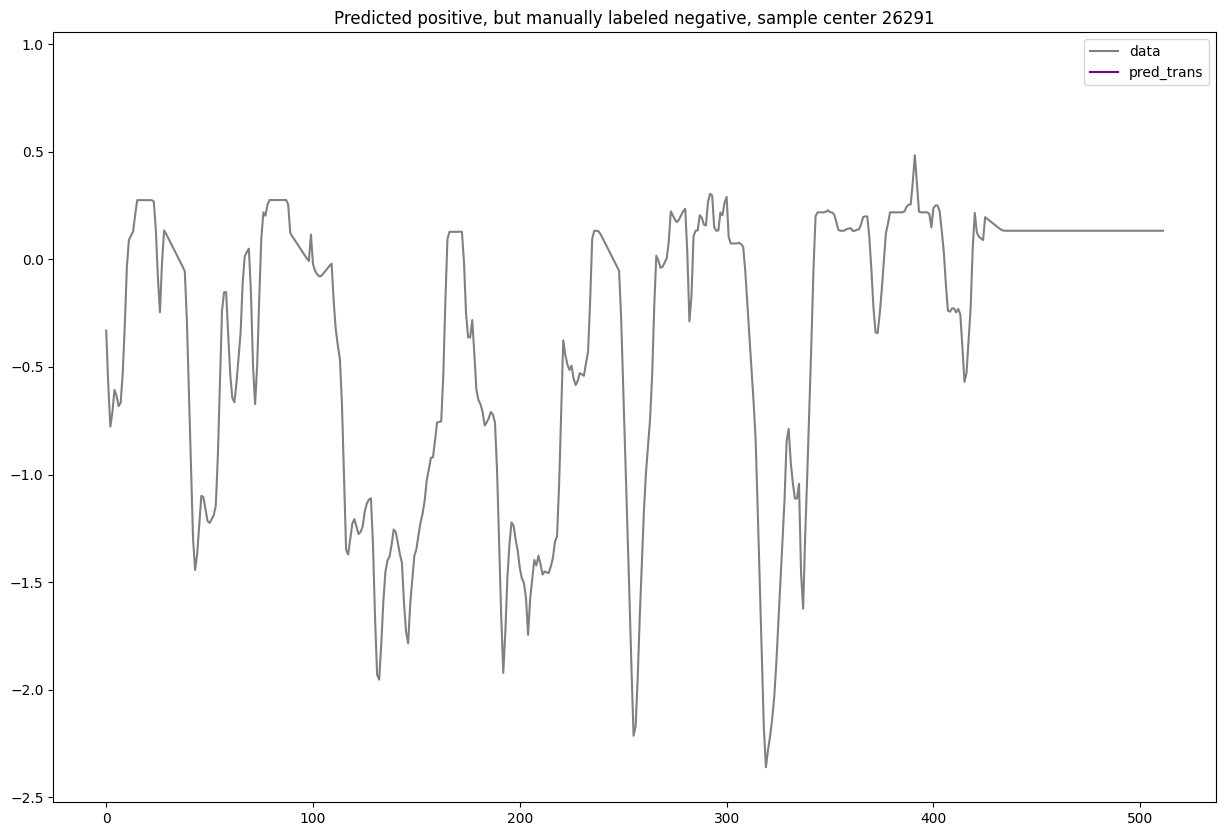

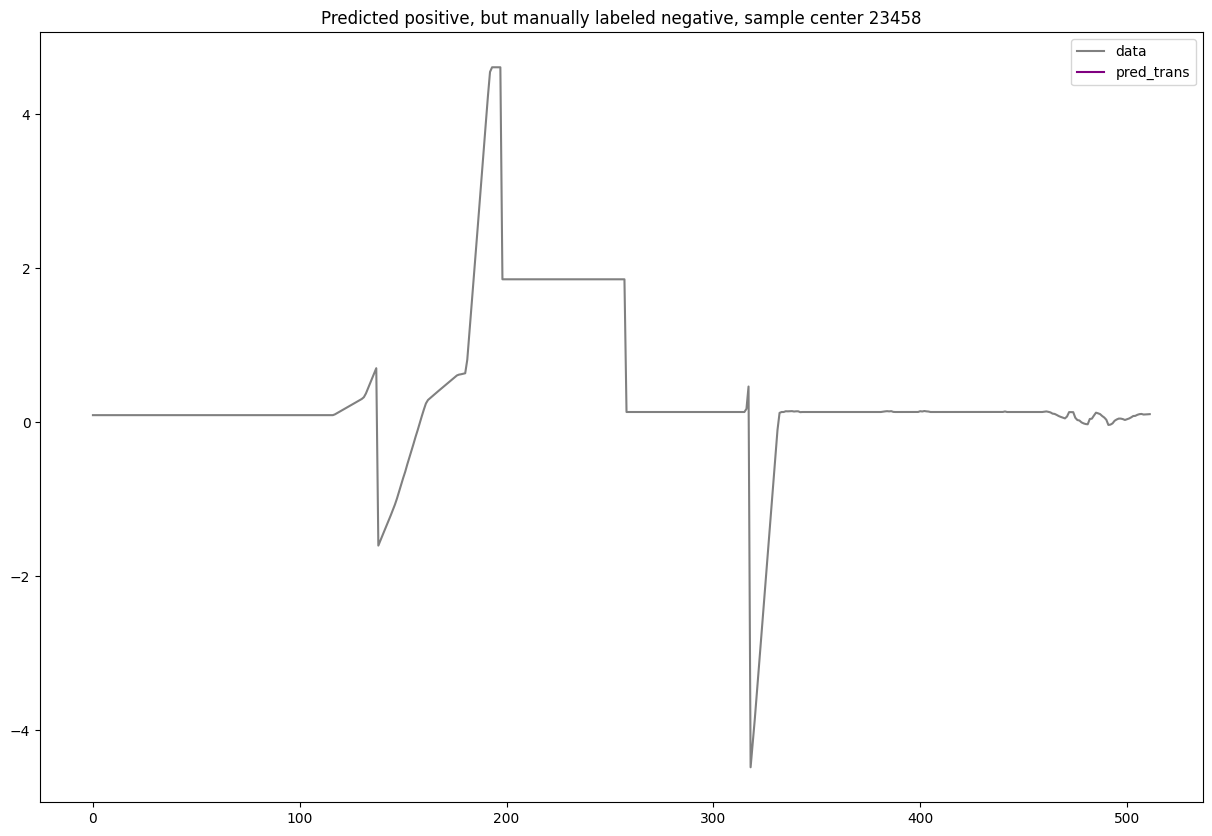

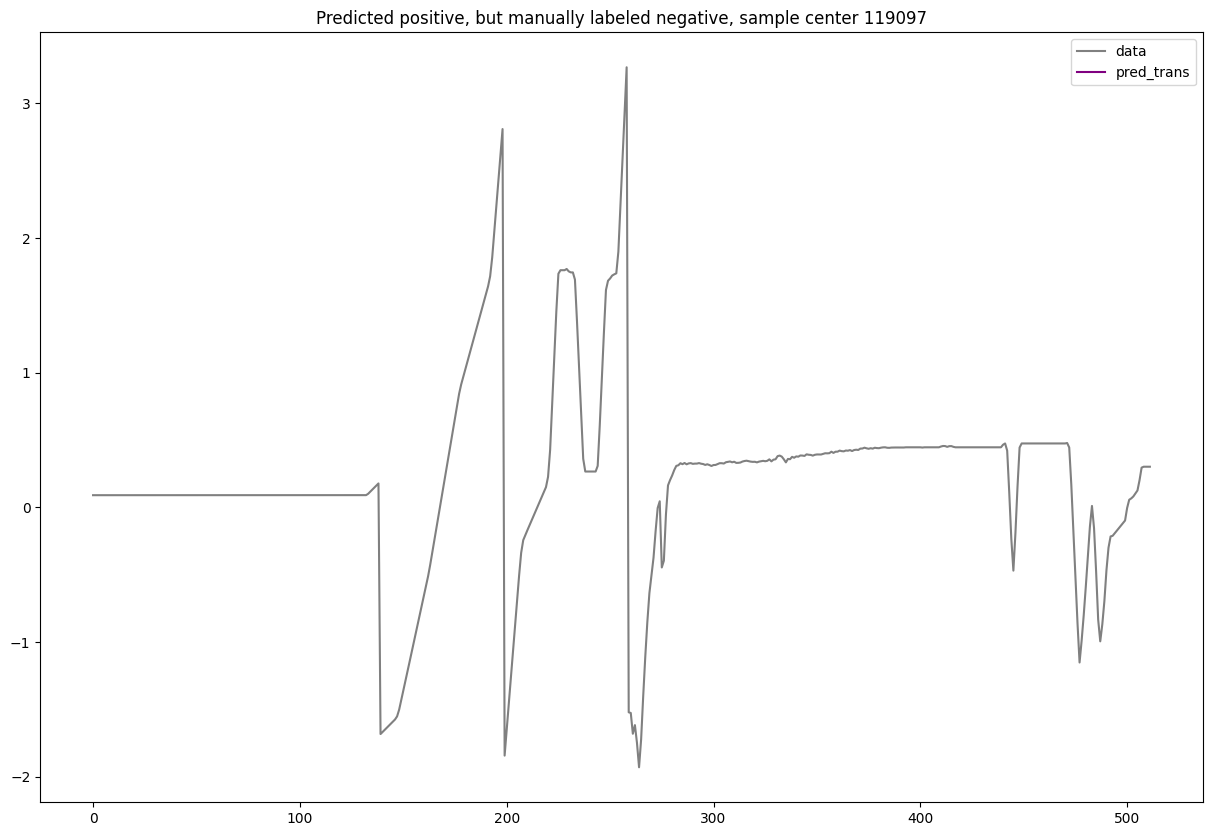

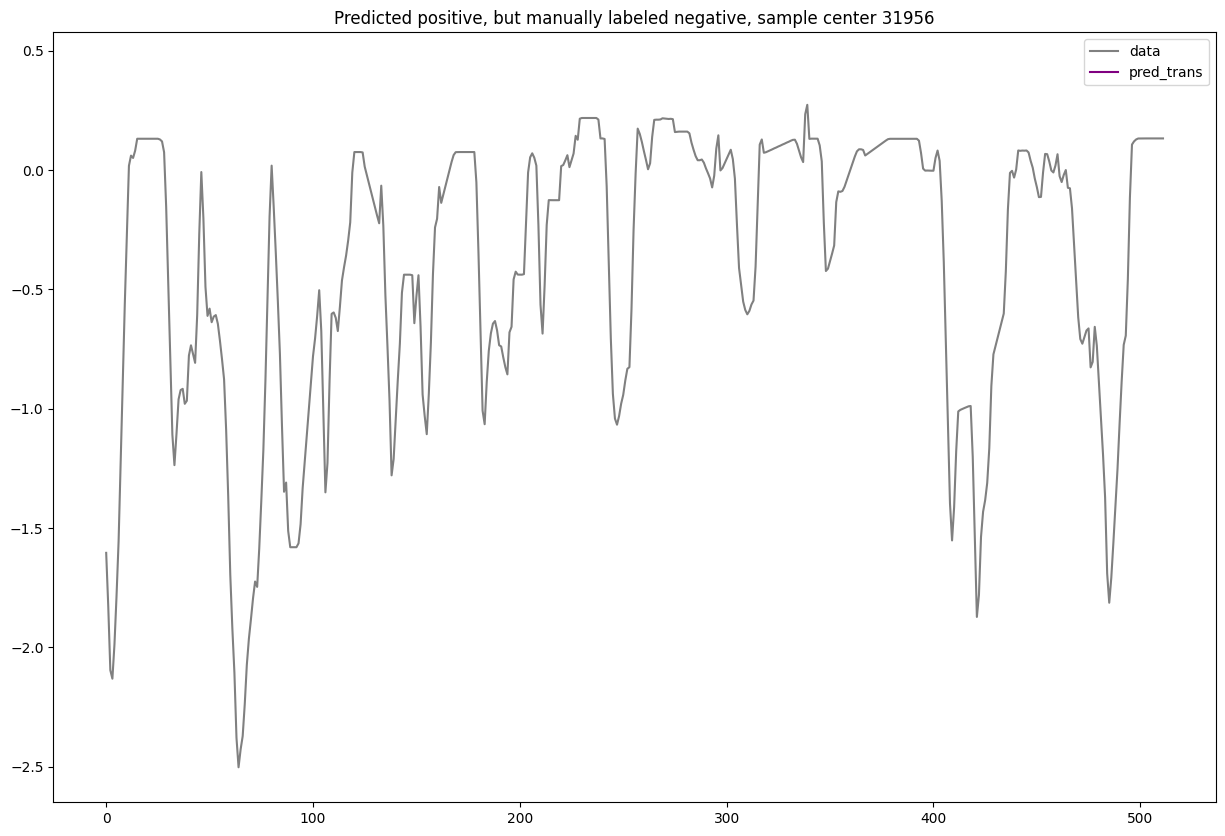

In [43]:
for index in fp_ind:
    example = torch.tensor(real_data_df[0][index-dist : index+dist])
    length  = len(example)

    prediction_trans = transformer_detector(example.unsqueeze(0))

    plt.figure(figsize=(15, 10))
    plt.plot(example, label="data", c="grey")
    plt.plot(prediction_trans, label="pred_trans", c="purple")
    plt.title(f"Predicted positive, but manually labeled negative, sample center {int(index)}")
    plt.legend()
    plt.show()

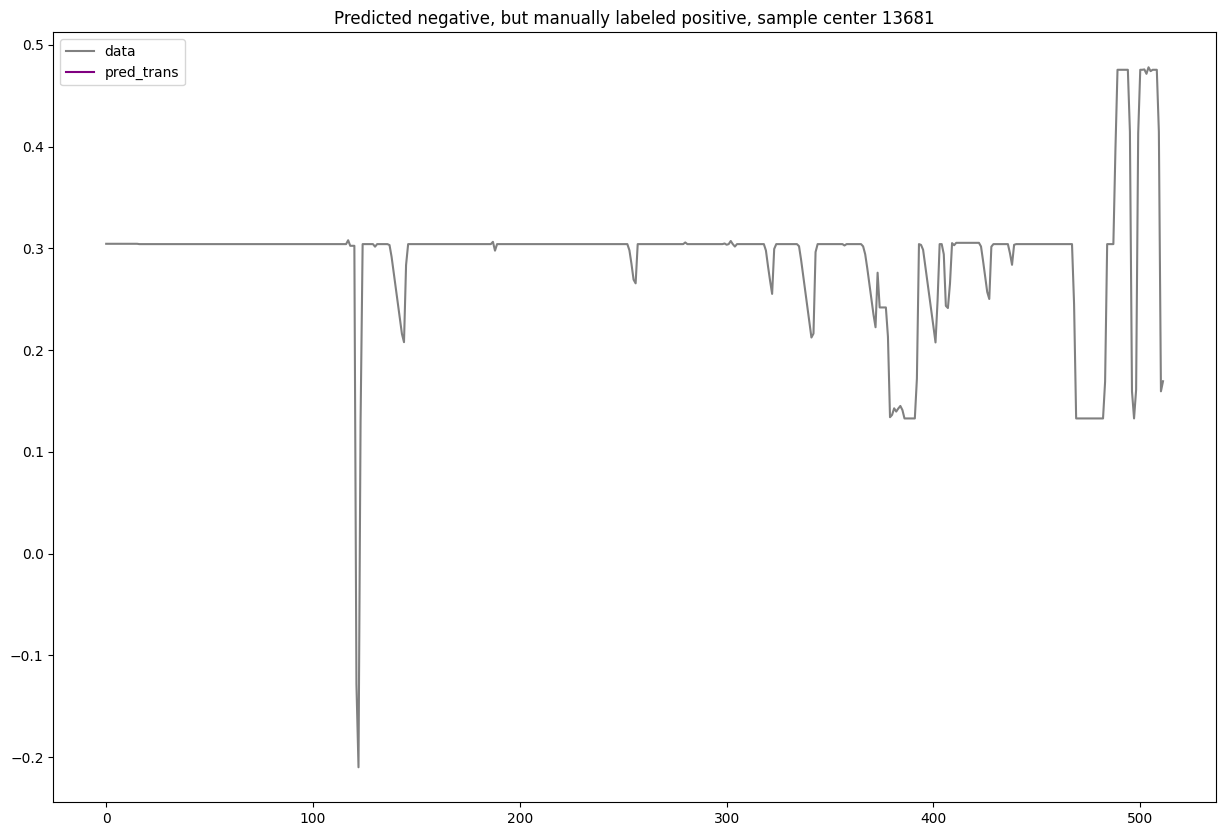

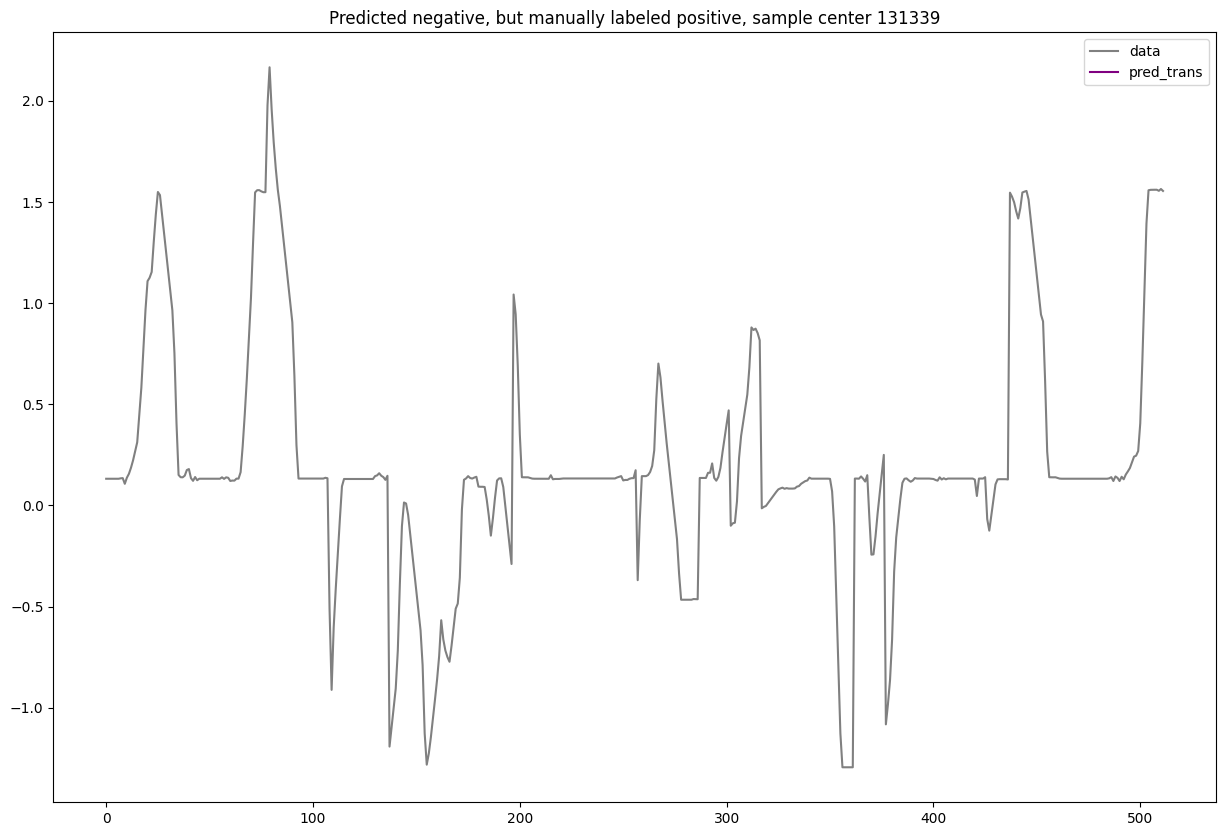

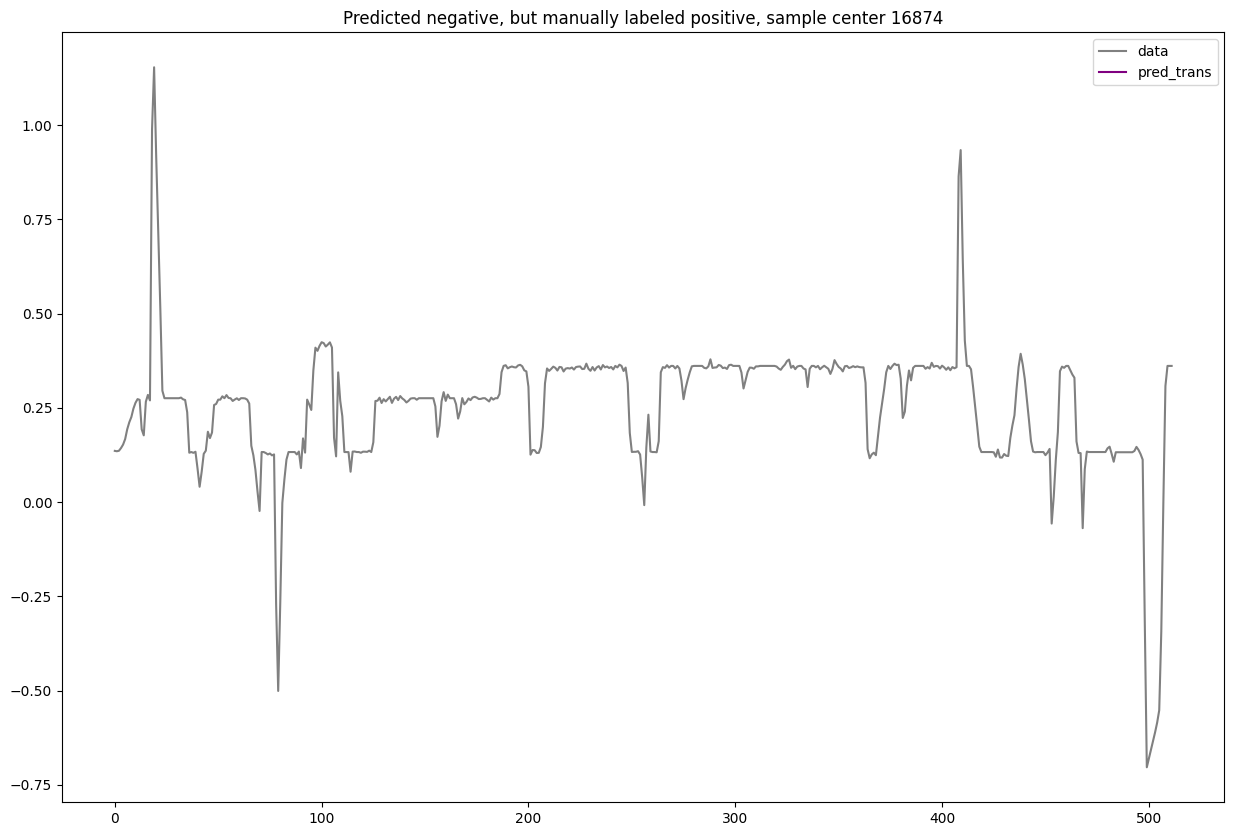

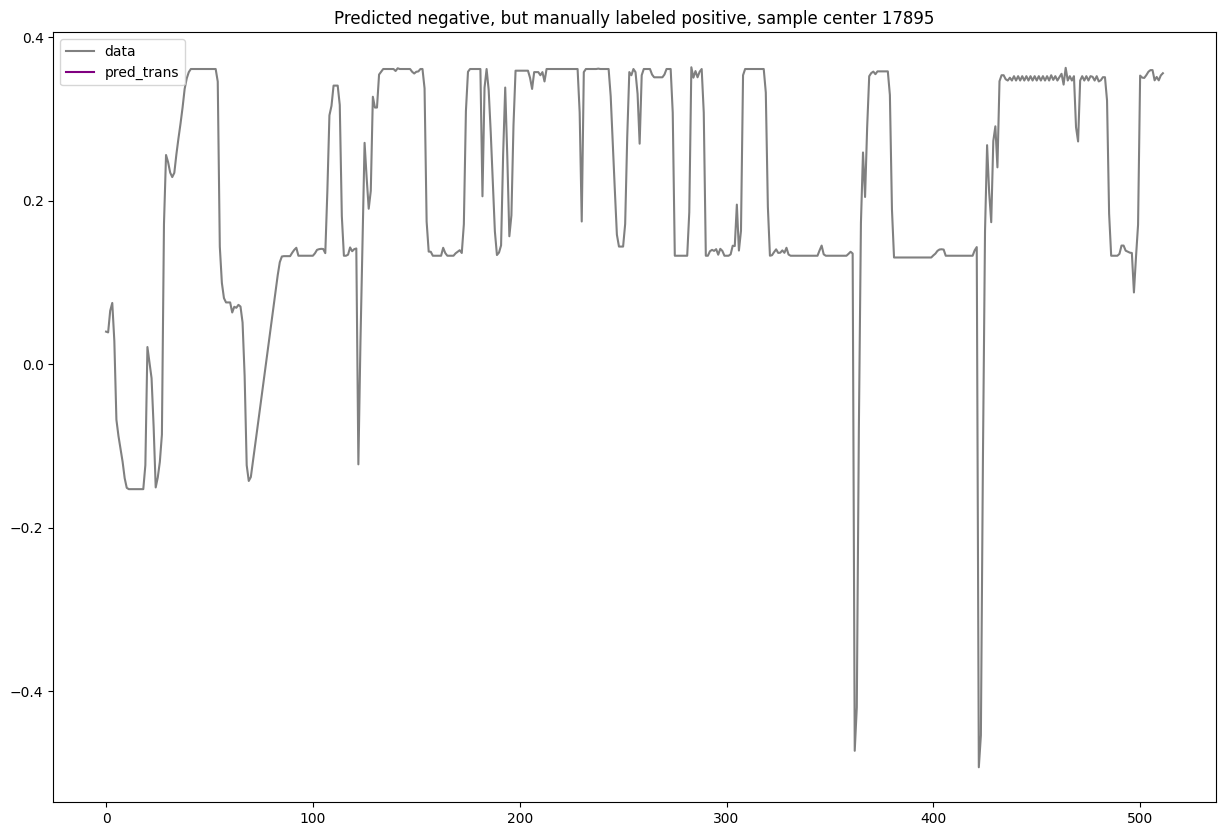

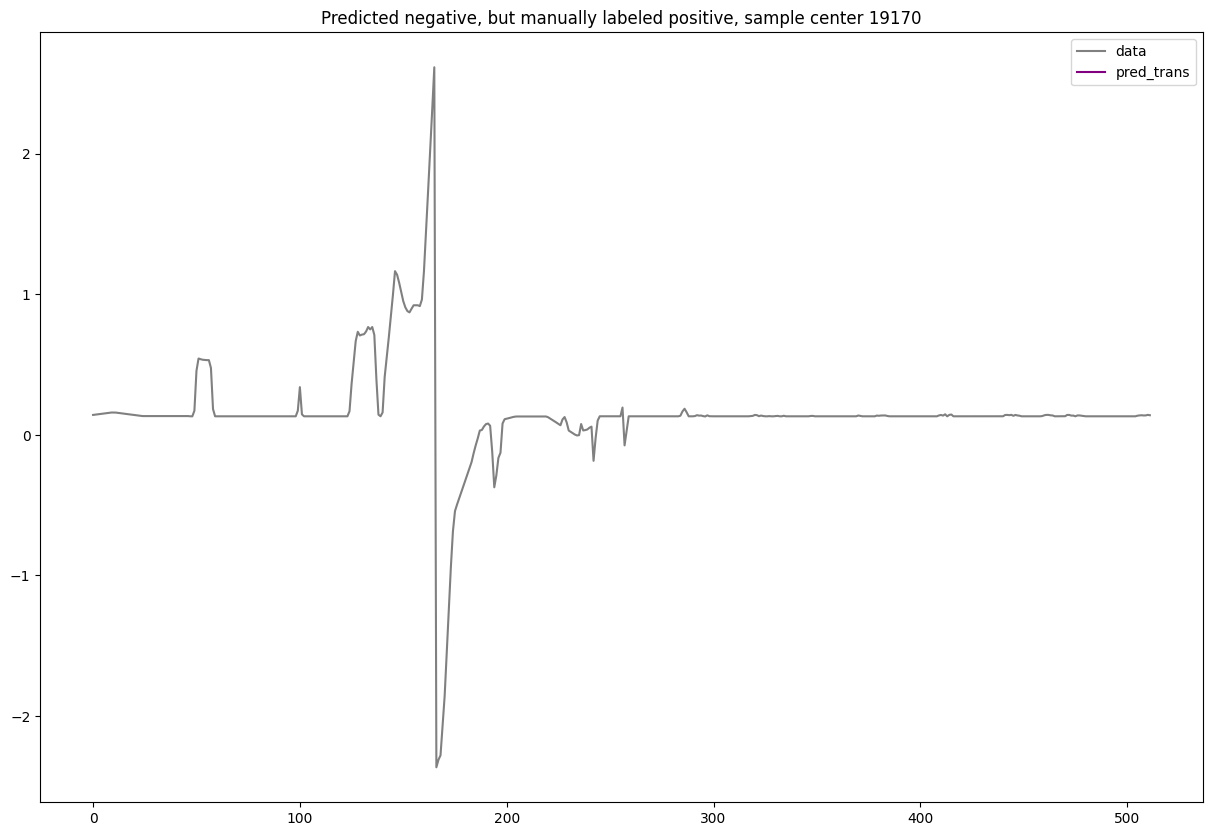

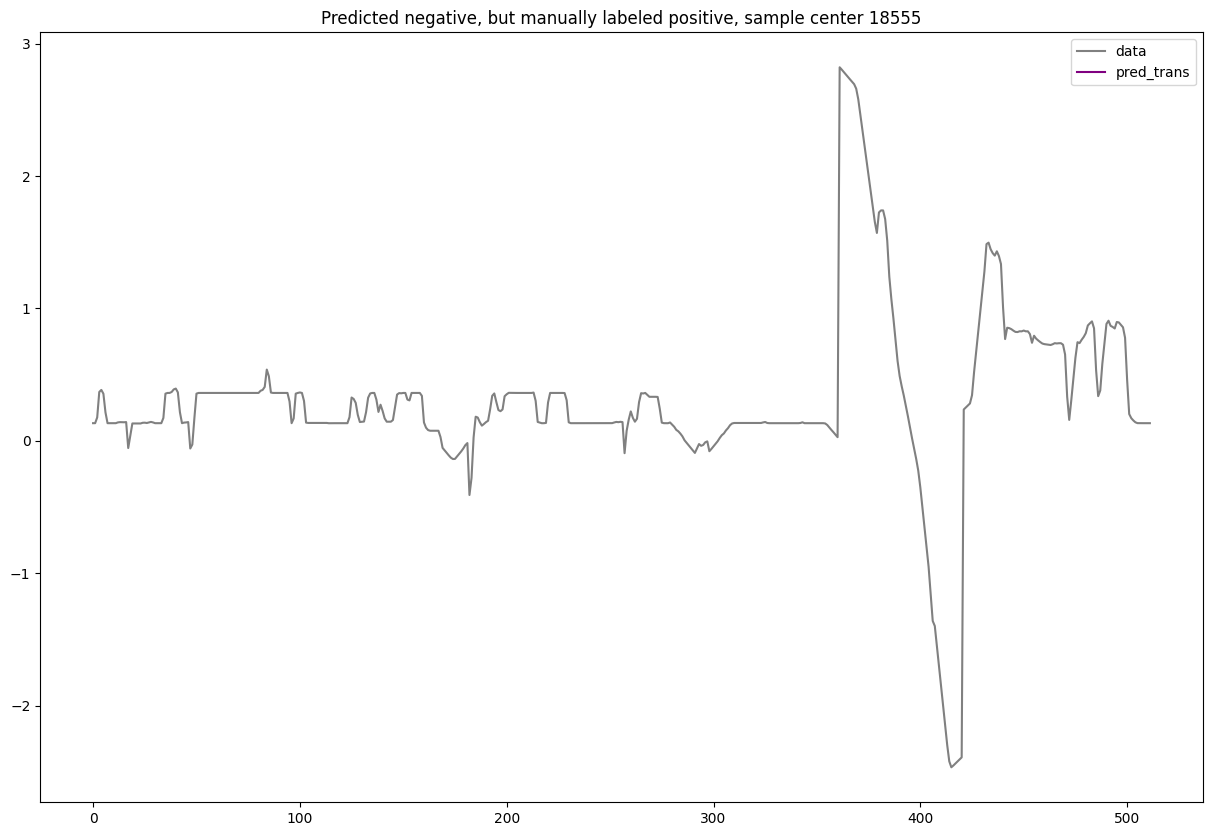

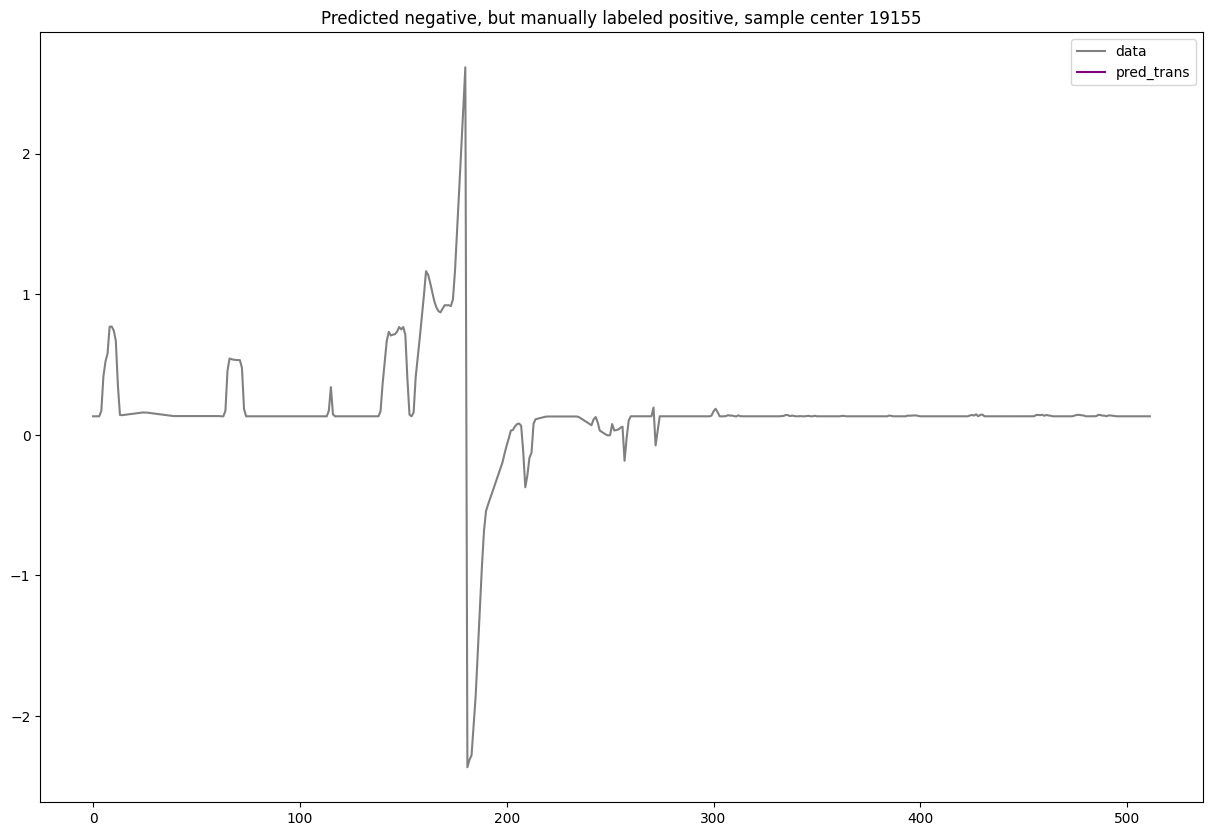

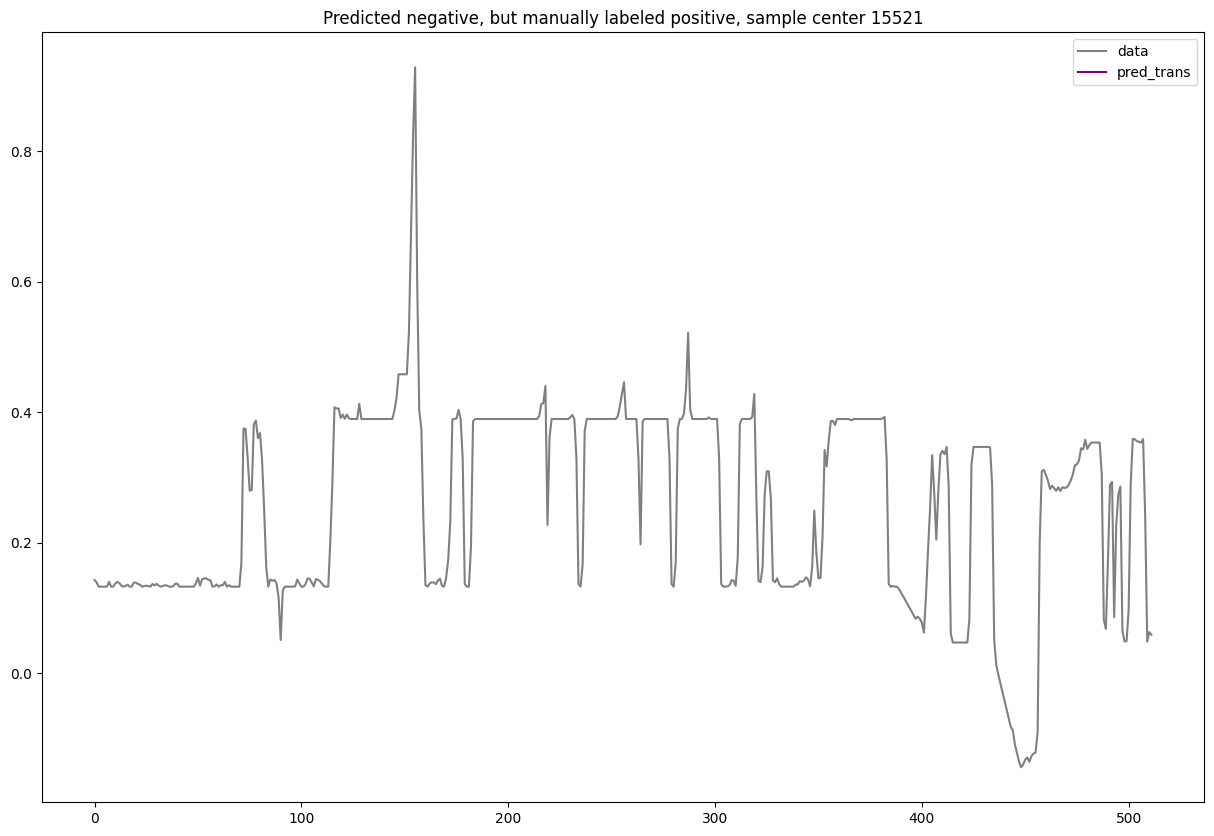

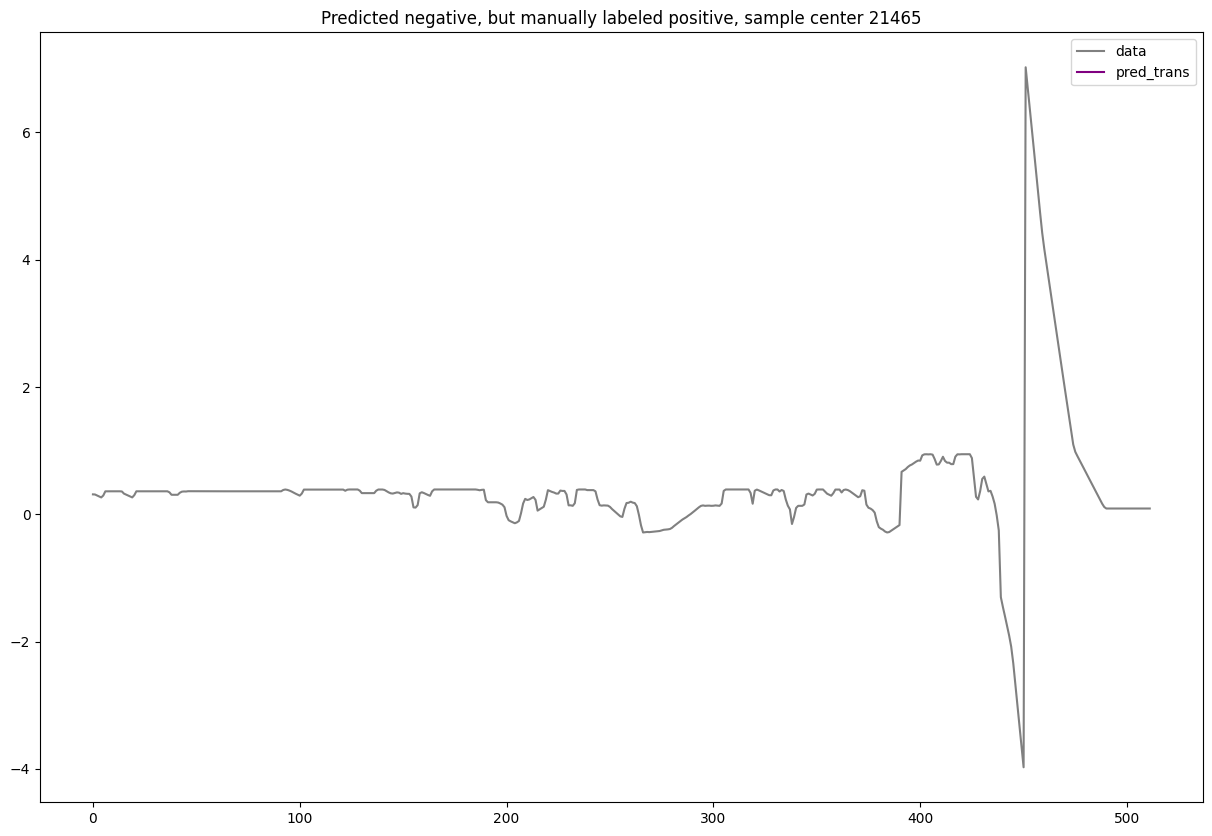

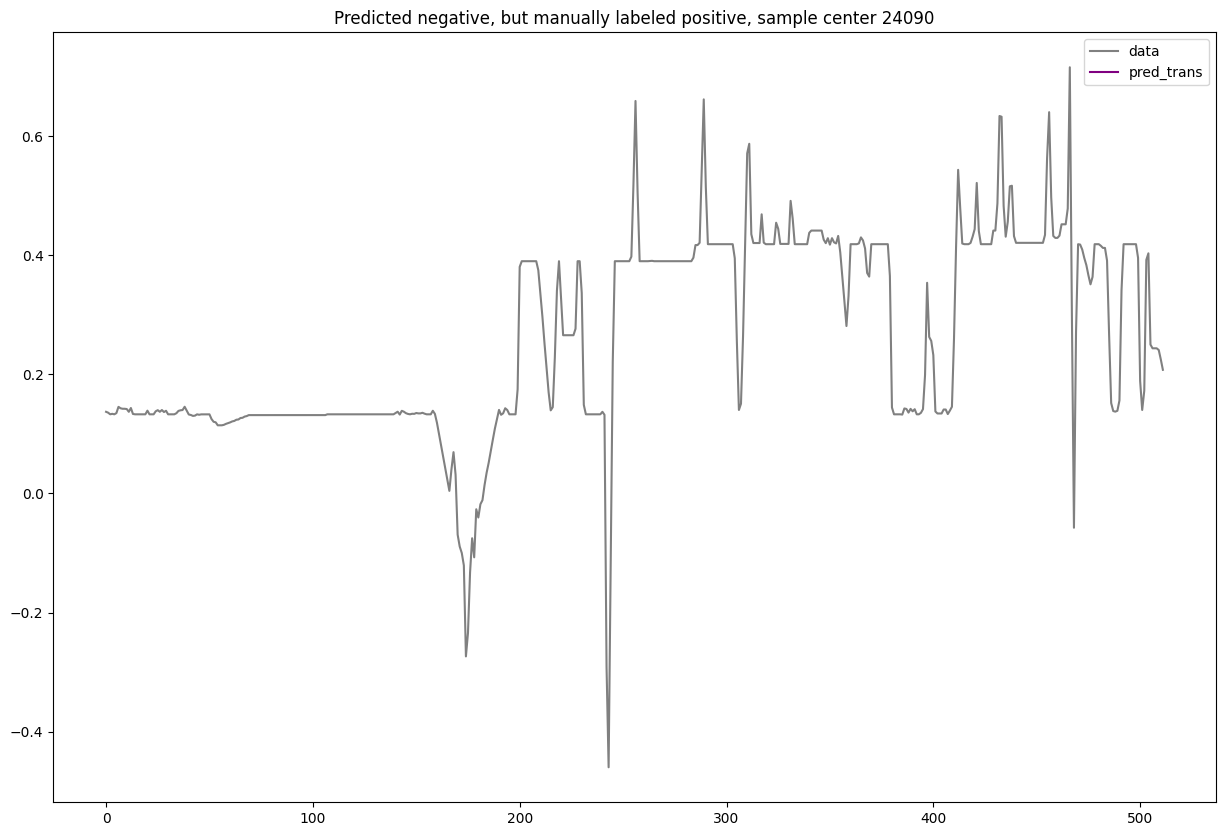

In [42]:
for index in fn_ind[:10]:
    example = torch.tensor(real_data_df[0][index-dist : index+dist])
    length  = len(example)

    prediction_trans = transformer_detector(example.unsqueeze(0))
    
    plt.figure(figsize=(15, 10))
    plt.plot(example, label="data", c="grey")
    plt.plot(prediction_trans, label="pred_trans", c="purple")
    plt.title(f"Predicted negative, but manually labeled positive, sample center {int(index)}")
    plt.legend()
    plt.show()

In [47]:
import pickle

# To write
with open('predictions.txt', 'wb') as file:
    pickle.dump(preds_trans, file)

# To write
with open('gt.txt', 'wb') as file:
    pickle.dump(gt, file)

In [1]:
import xgboost as xgb

In [ ]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

In [ ]:
evallist = [(dtrain, 'train'), (dtest, 'eval')]